### Cointegration Overview
https://www.youtube.com/watch?v=q5wbOSjbVW4

Finds if for two stocks $x_t$ and $y_t$, \
    if $y_t - \beta x_t$ is stationary

Fit linear regression, find estimators $\alpha$ and $\beta$ such that \
    $y_t = \alpha+ \beta x_t + u_t$, where $u_t$ is the residuals \
    then $u_t$ should be stationary

Then try to find $u_t = \delta_0 + \delta_1 u_{t-1} + \delta_2 u_{t-2} + ...$ \
    find if $\delta_1$ does not follow a Dickey-Fuller distribution, \
    if so we can reject the null and say that we have found a stationary pair

But, it is scuffed because this is assuming $\beta$ is correct, when we just estimated it \
    instead, we can use some other more stringent Dickey-Fuller distribution

TLDR: just run the test tbh, it just gives a p-value for pairs trading, may be scuffed

In [3]:
""" 
Imports
"""

import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from itertools import combinations
from tqdm import tqdm

In [4]:
""" 
Stocks df is already saved to hourlyData.csv now,
    and original Gio data is deleted
    + only tickers ending with USDT saved

Loads data from saved csv
"""

start_time = datetime(2024, 6, 1, 0, 0)
end_time = datetime(2024, 8, 25, 0, 0)
test_end_time = datetime(2024, 10, 7, 0, 0)


stocksDf = pd.read_csv('./crypto_data.csv')
stocksDf['time'] = pd.to_datetime(stocksDf['time'])
stocksDf = stocksDf.set_index('time')
stocksDf = stocksDf.loc[start_time:end_time]

stocksDf = stocksDf.dropna(how='all', axis=0)
stocksDf = stocksDf.dropna(how='all', axis=1)
display(stocksDf.head())
display(stocksDf.tail())

closeDf = stocksDf.filter(regex='_close$')
closeDf.columns = closeDf.columns.str.replace('_close$', '', regex=True)
display(closeDf.head())

,1INCHUSDT_open,1INCHUSDT_high,1INCHUSDT_low,1INCHUSDT_close,1INCHUSDT_volume,1INCHUSDT_turnover,USDEUSDT_open,USDEUSDT_high,USDEUSDT_low,USDEUSDT_close,...,QIUSDT_low,QIUSDT_close,QIUSDT_volume,QIUSDT_turnover,FLOWUSDT_open,FLOWUSDT_high,FLOWUSDT_low,FLOWUSDT_close,FLOWUSDT_volume,FLOWUSDT_turnover
time,,,,,,,,,,,,,,,,,,,,,
2024-06-01 00:00:00,0.5005,0.5059,0.4963,0.5044,1330970.3,6.682596e+05,NaN,NaN,NaN,NaN,...,0.02034,0.02059,7720980.0,159597.8528,0.8726,0.8753,0.8702,0.8737,12920.8,11281.11612
2024-06-01 01:00:00,0.5044,0.5094,0.5017,0.5091,1087224.9,5.491574e+05,NaN,NaN,NaN,NaN,...,0.02012,0.02034,17248230.0,353929.9628,0.8737,0.8760,0.8722,0.8727,17197.8,15028.97991
2024-06-01 02:00:00,0.5091,0.5128,0.5046,0.5072,1222070.0,6.222528e+05,NaN,NaN,NaN,NaN,...,0.02032,0.02051,8553340.0,175406.3059,0.8727,0.8734,0.8705,0.8729,30430.2,26533.50645
2024-06-01 03:00:00,0.5072,0.5150,0.4994,0.5026,3143888.3,1.594198e+06,NaN,NaN,NaN,NaN,...,0.02051,0.02086,7904890.0,164129.6272,0.8729,0.8741,0.8711,0.8712,34357.3,29979.44155
2024-06-01 04:00:00,0.5026,0.5066,0.4984,0.5025,1193780.4,5.997729e+05,NaN,NaN,NaN,NaN,...,0.02066,0.02076,6492190.0,135356.3587,0.8712,0.8761,0.8712,0.8735,42043.7,36723.01386


,1INCHUSDT_open,1INCHUSDT_high,1INCHUSDT_low,1INCHUSDT_close,1INCHUSDT_volume,1INCHUSDT_turnover,USDEUSDT_open,USDEUSDT_high,USDEUSDT_low,USDEUSDT_close,...,QIUSDT_low,QIUSDT_close,QIUSDT_volume,QIUSDT_turnover,FLOWUSDT_open,FLOWUSDT_high,FLOWUSDT_low,FLOWUSDT_close,FLOWUSDT_volume,FLOWUSDT_turnover
time,,,,,,,,,,,,,,,,,,,,,
2024-08-24 20:00:00,0.2826,0.2839,0.2780,0.2784,647862.2,182698.54044,0.9973,0.9981,0.9973,0.9979,...,0.01568,0.01575,2240800.0,35625.6434,0.6128,0.6294,0.6075,0.6106,1120678.9,694240.78798
2024-08-24 21:00:00,0.2784,0.2802,0.2741,0.2770,886843.3,245600.68846,0.9979,0.9983,0.9974,0.9976,...,0.01556,0.01567,1557970.0,24547.6190,0.6106,0.6226,0.6010,0.6064,1388782.1,850165.66248
2024-08-24 22:00:00,0.2770,0.2816,0.2769,0.2796,430558.9,120257.55249,0.9976,0.9978,0.9974,0.9974,...,0.01566,0.01593,987960.0,15655.9010,0.6064,0.6132,0.6063,0.6101,357913.7,218254.26920
2024-08-24 23:00:00,0.2796,0.2803,0.2764,0.2791,563969.8,156899.47845,0.9974,0.9976,0.9974,0.9974,...,0.01568,0.01577,1196490.0,18951.2342,0.6101,0.6112,0.6030,0.6075,375462.4,227803.47954
2024-08-25 00:00:00,0.2791,0.2796,0.2763,0.2795,310603.9,86386.95988,0.9974,0.9978,0.9973,0.9977,...,0.01563,0.01582,977070.0,15435.5667,0.6075,0.6079,0.6016,0.6073,201693.8,121984.95778


,1INCHUSDT,USDEUSDT,UNFIUSDT,ACEUSDT,AAVEUSDT,REEFUSDT,FORTHUSDT,UNIUSDT,ROSEUSDT,FOXYUSDT,...,10000000AIDOGEUSDT,FLMUSDT,NEOUSDT,EDUUSDT,1000XECUSDT,NTRNUSDT,1CATUSDT,ETHFIPERP,QIUSDT,FLOWUSDT
time,,,,,,,,,,,,,,,,,,,,,
2024-06-01 00:00:00,0.5044,NaN,4.7900,5.706,105.13,0.002154,4.3860,10.020,0.10039,0.023638,...,0.005366,0.09868,14.583,0.8538,0.04629,0.7215,0.004841,4.802,0.02059,0.8737
2024-06-01 01:00:00,0.5091,NaN,4.7590,5.725,104.65,0.002157,4.3853,10.025,0.09937,0.023992,...,0.005383,0.09838,14.563,0.8500,0.04630,0.7188,0.004846,4.781,0.02034,0.8727
2024-06-01 02:00:00,0.5072,NaN,4.7585,5.671,104.64,0.002148,4.3633,10.015,0.09888,0.023876,...,0.005339,0.09872,14.550,0.8493,0.04630,0.7202,0.004880,4.718,0.02051,0.8729
2024-06-01 03:00:00,0.5026,NaN,4.7520,5.653,104.20,0.002139,4.3530,10.003,0.09848,0.024137,...,0.005363,0.09823,14.488,0.8516,0.04618,0.7168,0.004924,4.742,0.02086,0.8712
2024-06-01 04:00:00,0.5025,NaN,4.7630,5.674,104.58,0.002135,4.3596,10.033,0.09825,0.023287,...,0.005367,0.09839,14.557,0.8528,0.04633,0.7204,0.004960,4.758,0.02076,0.8735


In [5]:
""" 
Use only low volume stocks (lowest 10%)
"""

tickers = closeDf.columns
volList = []

for ticker in tickers:
    prices = stocksDf[f'{ticker}_open']
    volumes = stocksDf[f'{ticker}_volume']
    combined = prices*volumes
    mean = combined.mean()
    volList.append((ticker, mean))

volList.sort(key=lambda x:x[1])

percentUsed = 10
lowestVolume = [pair[0] for pair in volList[:len(volList)*percentUsed//100]]
lowestVolume

['STRKPERP',
 'ARBPERP',
 'MNTPERP',
 'SHIB1000PERP',
 'ETHFIPERP',
 'DOGEPERP',
 'AEVOPERP',
 'EIGENUSDT',
 'WLDPERP',
 'SUIPERP',
 'ETCPERP',
 'TIAPERP',
 'ONDOPERP',
 'ORDIPERP',
 'ETH-25OCT24',
 'OPPERP',
 'FUNUSDT',
 'TONPERP',
 '1000PEPEPERP',
 'CEEKUSDT',
 'XRDUSDT',
 'WIFPERP',
 'BNBPERP',
 'LTOUSDT',
 'VTHOUSDT',
 'BTC-25OCT24',
 'SCRTUSDT',
 'OSMOUSDT',
 'XNOUSDT',
 'USDEUSDT',
 'ETH-28MAR25',
 'GNOUSDT',
 'OGUSDT',
 'FDUSDUSDT',
 'BOBAUSDT',
 'XCNUSDT',
 'ETH-27DEC24',
 'XCHUSDT',
 'IDEXUSDT',
 'CETUSUSDT',
 'DGBUSDT',
 'BALUSDT']

In [6]:
# Drop stocks w/o full data
subsetDf = closeDf.loc[:,lowestVolume]
subsetDf = subsetDf.dropna(how='any', axis=1)
subsetDf.head()
len(subsetDf.columns)

37

In [7]:
# Run cointegration
results = []

for col1, col2 in tqdm(list(combinations(subsetDf.columns, 2))):
    coin_result = coint(closeDf[col1], closeDf[col2], trend='c') #coin_result is tuple of statistics
    results.append([coin_result, col1, col2])

    p_value = coin_result[1]

100%|██████████| 666/666 [00:27<00:00, 24.56it/s]


In [10]:
results.sort(key=lambda x:x[0][1]) # sort by increasing p-value

for i in range(20):
    result = results[i]
    p_value = result[0][1]
    stock1, stock2 = result[1], result[2]
    print(stock1, stock2, p_value)

OPPERP BOBAUSDT 5.073830897883026e-06
SHIB1000PERP BOBAUSDT 1.632959830524447e-05
ETCPERP BOBAUSDT 0.00011531943153825023
FUNUSDT OGUSDT 0.00012858889570514236
BOBAUSDT XCNUSDT 0.00027083399189783546
ETCPERP XCNUSDT 0.00039133658787195597
ONDOPERP SCRTUSDT 0.0004473600889653364
CEEKUSDT BOBAUSDT 0.0005169439551759593
CEEKUSDT OSMOUSDT 0.0008071531751343175
XCHUSDT BALUSDT 0.0011637519829858958
OGUSDT BOBAUSDT 0.0021544394962982405
FUNUSDT BOBAUSDT 0.0025652803860289133
SHIB1000PERP OGUSDT 0.003014799849652773
OSMOUSDT BOBAUSDT 0.003190496882433739
ARBPERP BOBAUSDT 0.003204487730773301
SHIB1000PERP AEVOPERP 0.003332764439946346
SCRTUSDT XCNUSDT 0.003516923105581413
SHIB1000PERP CEEKUSDT 0.0038496934718516007
ARBPERP ONDOPERP 0.003865081664273118
LTOUSDT IDEXUSDT 0.004351792520366502


In [11]:
import statsmodels.api as sm

# See if the pairs seem like they are actually mean reverting
def checkPair(stock1, stock2, graph=True):
    x = closeDf[stock1]
    x_const = sm.add_constant(x)
    y = closeDf[stock2]

    model = sm.OLS(y, x_const)
    r = model.fit()
    const, slope = r.params

    signal = y - (slope*x + const)
    std = np.std(signal)
    print(f"test_statarb('{stock2}', '{stock1}', {slope:.5g}, {const:.5g}, {std:.5g})") # print commands

    if not graph: return
    
    combined = y - (slope*x + const)

    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    fig.tight_layout()

    tick_locs = combined.index[::len(combined)//4]

    combinedPlot = axs[0]
    combinedPlot.plot(combined)
    combinedPlot.set_title(f'{stock2} Close - ({slope:.4g} * {stock1} Close + {const:.4g})')
    combinedPlot.set_xticks(tick_locs, tick_locs, rotation=45)

    stock1Plot = axs[1]
    stock1Plot.plot(x)
    stock1Plot.set_title(f'{stock1} Close')
    stock1Plot.set_xticks(tick_locs, tick_locs, rotation=45)

    stock2Plot = axs[2]
    stock2Plot.plot(y)
    stock2Plot.set_title(f'{stock2} Close')
    stock2Plot.set_xticks(tick_locs, tick_locs, rotation=45)

test_statarb('BOBAUSDT', 'OPPERP', 0.11161, 0.055405, 0.0069314)
test_statarb('BOBAUSDT', 'SHIB1000PERP', 10.91, 0.058972, 0.0066636)
test_statarb('BOBAUSDT', 'ETCPERP', 0.01217, -0.025953, 0.0076501)
test_statarb('OGUSDT', 'FUNUSDT', 882.14, -0.094366, 0.090828)


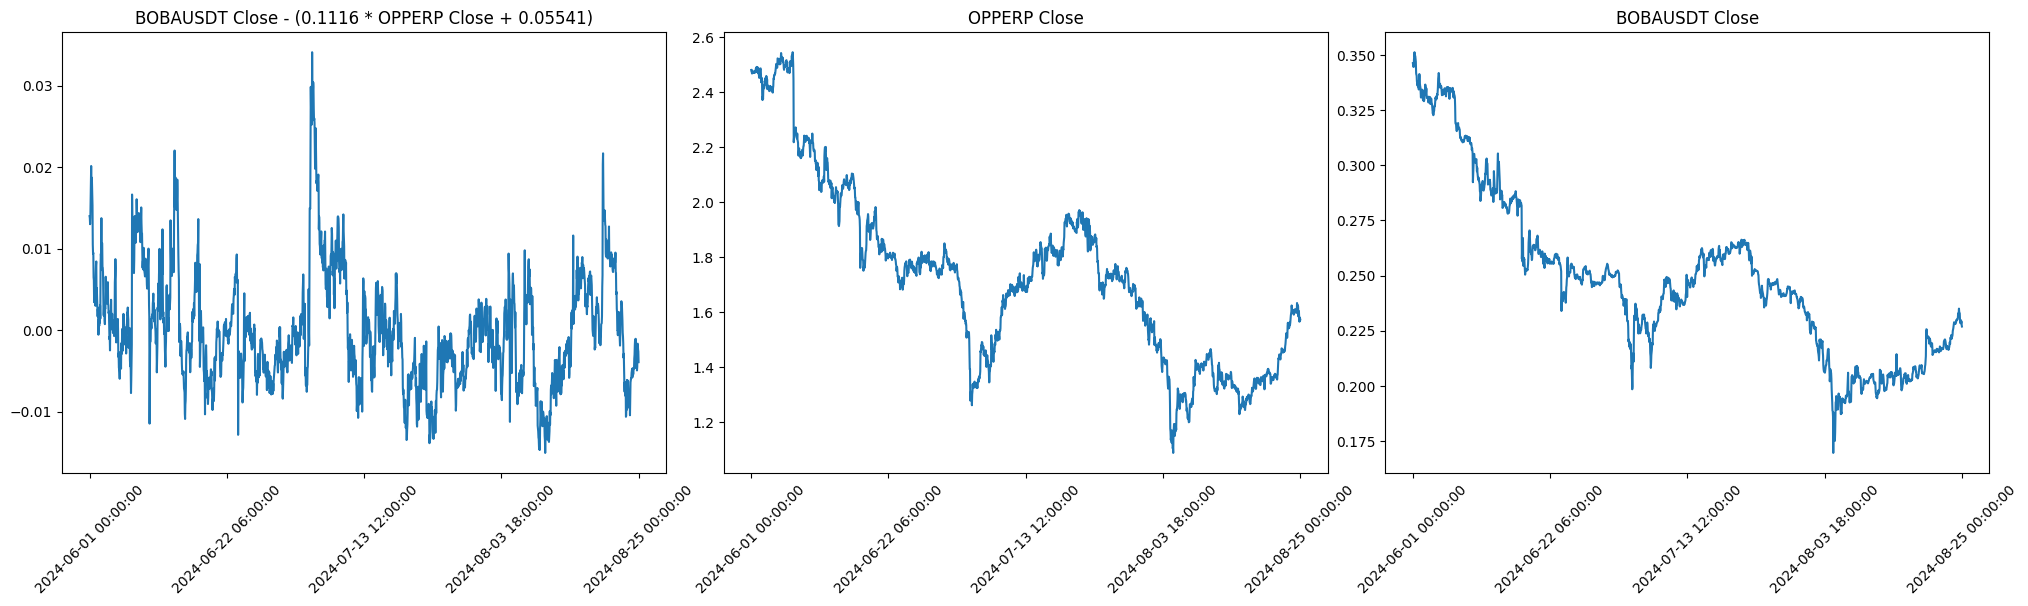

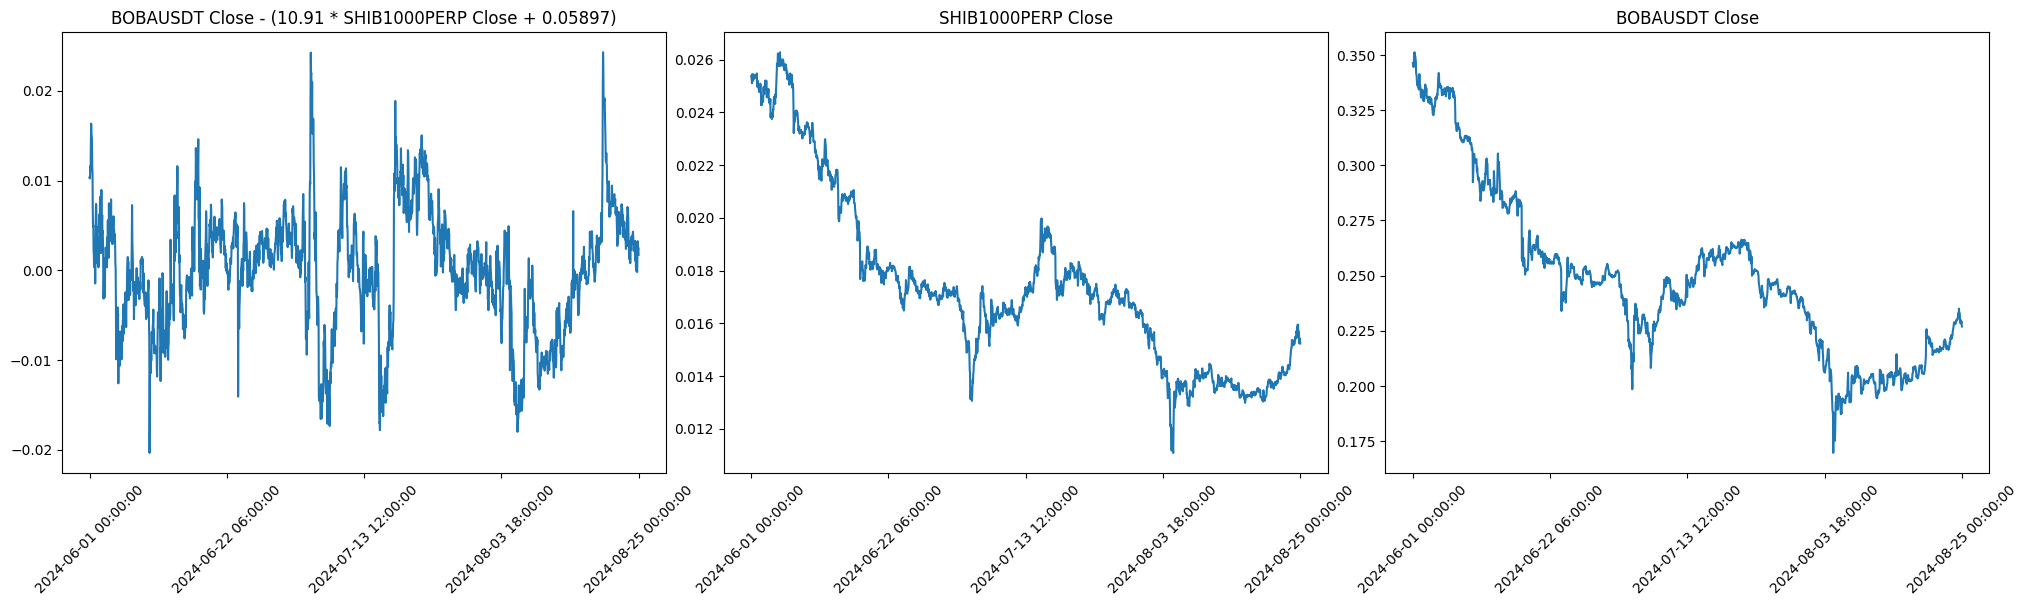

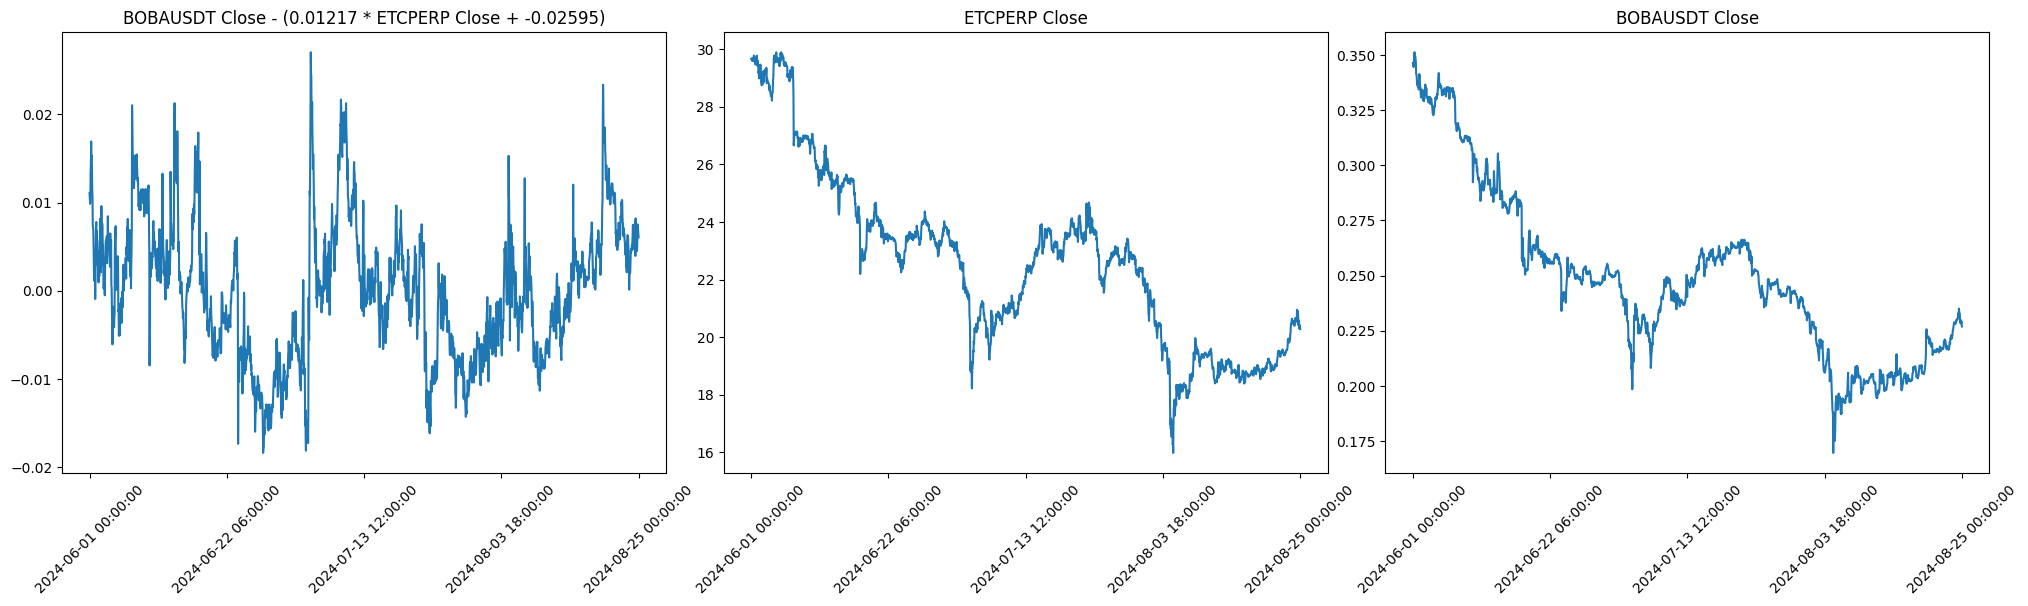

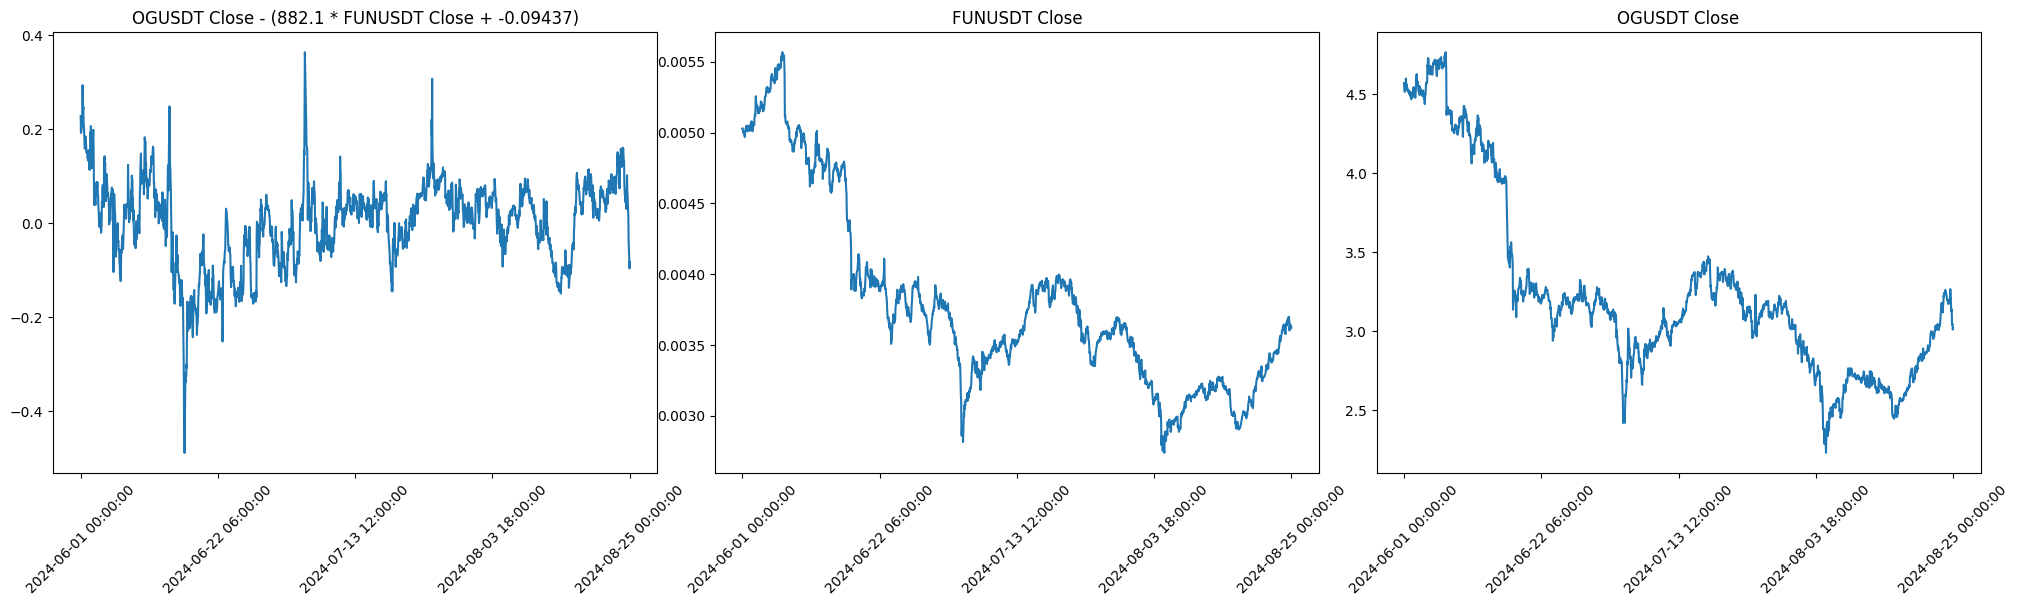

In [12]:
for i in range(4):
    stock1, stock2 = results[i][1], results[i][2]
    checkPair(stock1, stock2, graph=True)